## BatTrain (chaz henry SEP-2021)
### train a new keypoint model for Detectron2 to recognize bat knob/tip

### Run this cell to refresh the dataset from PowerChalk

In [1]:
import os, shutil
folder = './data/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [2]:
from tqdm import tqdm
import wget
import os

data_url = 'http://www.powerchalk.com/streams/battrain/battrain.zip'
data_file = wget.download(data_url, out='temp/')
print(f'Data file: {data_file}')

Data file: temp//battrain.zip


In [3]:
import zipfile
data_file = 'temp/battrain.zip'
with zipfile.ZipFile(data_file, 'r') as zip_ref:
    zip_ref.extractall('data/')

#### Train/Test splitter
##### Annotations are in a single file: `labels.json` This leaves the JPGs in place but creates a test and train json file to accomplish splitting.

In [4]:
import json
import argparse
import funcy
from sklearn.model_selection import train_test_split

annotationsFile = 'data/labels.json'
trainAnnoFile = 'data/train.json'
testAnnoFile = 'data/test.json'
splitPercent = 0.9
mustHaveAnno = True

def save_coco(file, info, licenses, images, annotations, categories):
    with open(file, 'wt', encoding='UTF-8') as coco:
        json.dump({ 'info': info, 'licenses': licenses, 'images': images, 
            'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)

def filter_annotations(annotations, images):
    image_ids = funcy.lmap(lambda i: int(i['id']), images)
    return funcy.lfilter(lambda a: int(a['image_id']) in image_ids, annotations)


with open(annotationsFile, 'rt', encoding='UTF-8') as annotations:
    coco = json.load(annotations)
    info = coco['info']
    licenses = coco['licenses']
    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']
    number_of_images = len(images)
    images_with_annotations = funcy.lmap(lambda a: int(a['image_id']), annotations)

    if mustHaveAnno:
        images = funcy.lremove(lambda i: i['id'] not in images_with_annotations, images)

    x, y = train_test_split(images, train_size=splitPercent, random_state=42)

    save_coco(trainAnnoFile, info, licenses, x, filter_annotations(annotations, x), categories)
    save_coco(testAnnoFile, info, licenses, y, filter_annotations(annotations, y), categories)

    print("Saved {} entries in {}".format(len(x), trainAnnoFile))
    print("Saved {} entries in {}".format(len(y), testAnnoFile))


Saved 2156 entries in data/train.json
Saved 240 entries in data/test.json


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import some common libraries
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger

from detectron2.data import (MetadataCatalog,
                             build_detection_train_loader,
                             build_detection_test_loader,
                             DatasetMapper, transforms as T,
                             detection_utils as utils)
setup_logger()

<Logger detectron2 (DEBUG)>

#### Register the new keypoint model

In [2]:
from detectron2.data.datasets import register_coco_instances
#register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
register_coco_instances("bat_train", {}, "data/train.json", "data")
register_coco_instances("bat_test", {}, "data/test.json", "data")

keypoint_names = ['knob', 'tip']
keypoint_flip_map = [('knob', 'tip')]

from detectron2.data import MetadataCatalog
classes = MetadataCatalog.get("bat_train").thing_classes = ["st_bat"]
print(classes)

MetadataCatalog.get("bat_train").thing_classes = ["st_bat"]
MetadataCatalog.get("bat_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("bat_train").keypoint_names = keypoint_names
MetadataCatalog.get("bat_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("bat_train").evaluator_type="coco"

['st_bat']


### Verify new keypoints by viewing annotation.

[10/20 06:09:25 d2.data.datasets.coco]: Loaded 2156 images in COCO format from data/train.json
Showing data/29_D4A38CD4-8693-0DA4-8693-F896F4BBB700_0081.jpg
Showing data/113066_0FB05C47-D446-A09D-36A2-795201D2BC9E_0117.jpg
Showing data/29_D4A38CD4-8693-0DA4-8693-F896F4BBB700_0076.jpg
Showing data/110_407ae073-6aad-4291-8d42-470e8bcc676b_0145.jpg
Showing data/113066_0FB05C47-D446-A09D-36A2-795201D2BC9E_0176.jpg


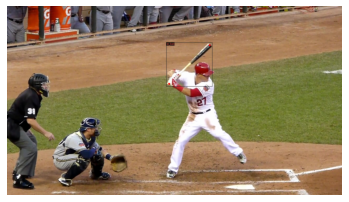

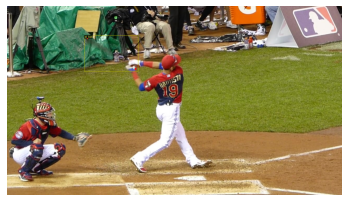

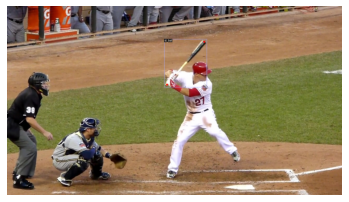

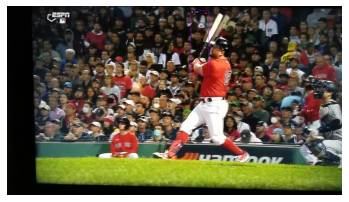

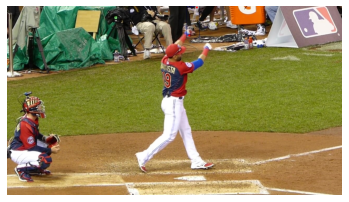

In [3]:
import random
from detectron2.utils.visualizer import Visualizer
dataset_dicts = DatasetCatalog.get("bat_train")
hands_metadata = MetadataCatalog.get("bat_train")
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');
    
for d in random.sample(dataset_dicts, 5):
    print("Showing " + d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=1)   
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Creating Custom Trainer with Data Augmentation

In [4]:
from detectron2.engine import DefaultTrainer
from typing import List, Optional, Union


class Trainer(DefaultTrainer):
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        is_train = True
        augs = utils.build_augmentation(cfg, is_train)
        augs.append(T.RandomBrightness(intensity_min=0.7, intensity_max=1.3))
        augs.append(T.RandomContrast(intensity_min=0.7, intensity_max=1.3))
        augs.append(T.RandomSaturation(intensity_min=0.7, intensity_max=1.3))
#         if cfg.INPUT.CROP.ENABLED and is_train:
#             augs.insert(0, T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE))
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, True, augmentations= augs))

### Train the model...

In [5]:
# Configs
EPOCHS = 10
BATCH_SIZE = 2
train_dataset_dicts = DatasetCatalog.get("bat_train")

cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bat_train",)

cfg.DATASETS.TEST = ("bat_test",)  #Dataset 'bat_test' is empty 
#cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.SOLVER.BASE_LR = 0.0008  # pick a good LR
cfg.SOLVER.MAX_ITER = len(train_dataset_dicts) // BATCH_SIZE * EPOCHS   # MAX_ITER = total images / batch size * epochs
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # bat
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 2
cfg.TEST.KEYPOINT_OKS_SIGMAS = tuple(np.ones(2, dtype=float).tolist())

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

[10/20 06:09:26 d2.data.datasets.coco]: Loaded 2156 images in COCO format from data/train.json


In [6]:
trainer = Trainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
print("Done!")

[10/20 06:09:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 2, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[10/20 06:09:33 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:983.)
  num_fg = fg_inds.nonzero().numel()


[10/20 06:09:45 d2.utils.events]:  eta: 1:35:09  iter: 19  total_loss: 8.656  loss_cls: 0.3651  loss_box_reg: 0.06809  loss_keypoint: 8.058  loss_rpn_cls: 0.1193  loss_rpn_loc: 0.009816  time: 0.5132  data_time: 0.0225  lr: 1.5985e-05  max_mem: 3868M
[10/20 06:09:56 d2.utils.events]:  eta: 1:35:42  iter: 39  total_loss: 8.707  loss_cls: 0.411  loss_box_reg: 0.03354  loss_keypoint: 8.09  loss_rpn_cls: 0.1309  loss_rpn_loc: 0.0132  time: 0.5225  data_time: 0.0052  lr: 3.1969e-05  max_mem: 3868M
[10/20 06:10:07 d2.utils.events]:  eta: 1:35:46  iter: 59  total_loss: 8.838  loss_cls: 0.3953  loss_box_reg: 0.09529  loss_keypoint: 8.057  loss_rpn_cls: 0.1292  loss_rpn_loc: 0.01012  time: 0.5261  data_time: 0.0048  lr: 4.7953e-05  max_mem: 3868M
[10/20 06:10:17 d2.utils.events]:  eta: 1:35:29  iter: 79  total_loss: 8.528  loss_cls: 0.2783  loss_box_reg: 0.03253  loss_keypoint: 8.002  loss_rpn_cls: 0.1531  loss_rpn_loc: 0.009696  time: 0.5231  data_time: 0.0048  lr: 6.3937e-05  max_mem: 3868M
[

### Load the newly built model and run it on a test image...

In [7]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold


def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');

predictor = DefaultPredictor(cfg)
im = cv2.imread("Screenshot 2021-10-15 114802.png")
outputs = predictor(im)
print(outputs)
o = outputs["instances"]
print("--------------------------------------------------------")


{'instances': Instances(num_instances=1, image_height=846, image_width=1427, fields=[pred_boxes: Boxes(tensor([[ 97.1044, 430.6289, 174.1234, 472.7448]], device='cuda:0')), scores: tensor([0.6681], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_keypoints: tensor([[[1.6289e+02, 4.5958e+02, 2.5352e-02],
         [1.1048e+02, 4.4379e+02, 1.4309e-02]]], device='cuda:0'), pred_keypoint_heatmaps: tensor([[[[-4.0867, -4.4612, -5.2104,  ..., -8.2931, -8.1461, -8.0726],
          [-4.2526, -4.5934, -5.2749,  ..., -8.6689, -8.5082, -8.4278],
          [-4.5845, -4.8576, -5.4040,  ..., -9.4205, -9.2323, -9.1383],
          ...,
          [-6.8189, -6.8475, -6.9045,  ..., -4.5335, -4.8279, -4.9751],
          [-6.8494, -7.0395, -7.4197,  ..., -4.9945, -4.8649, -4.8001],
          [-6.8647, -7.1355, -7.6773,  ..., -5.2249, -4.8834, -4.7127]],

         [[-4.0054, -4.1247, -4.3633,  ..., -7.9795, -7.3808, -7.0814],
          [-4.0917, -4.1814, -4.3607,  ..., -8.2839, -7.8460, -7.

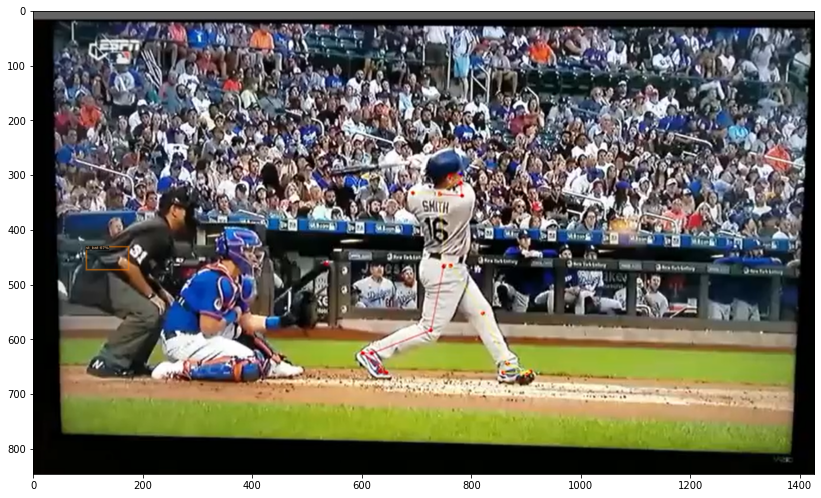

In [8]:
v = Visualizer(im[:, :, ::-1], metadata=hands_metadata, scale=1)    # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bat_test", output_dir="./output", kpt_oks_sigmas = tuple(np.ones((2,1), dtype=float).tolist()))
val_loader = build_detection_test_loader(cfg, "bat_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[10/18 05:32:38 d2.data.datasets.coco]: Loaded 205 images in COCO format from data/test.json
[10/18 05:32:38 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   st_bat   | 205          |
|            |              |
[10/18 05:32:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/18 05:32:38 d2.data.common]: Serializing 205 elements to byte tensors and concatenating them all ...
[10/18 05:32:38 d2.data.common]: Serialized dataset takes 0.06 MiB
[10/18 05:32:38 d2.evaluation.evaluator]: Start inference on 205 batches
[10/18 05:32:40 d2.evaluation.evaluator]: Inference done 11/205. Dataloading: 0.0011 s/iter. Inference: 0.1102 s/iter. Eval: 0.0003 s/iter. Total: 0.1115 s/iter. ETA=0:00:21
[10/18 05:32:45 d2.evaluation.evaluator]: Inference done 57/205. Dataloading: 0.0014 s/iter. Inference: 0.1